In [2]:
# import 
import math
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import seaborn as sns

# attention score function

attention pooling function 可以看作利用 attention score function以及softmax後的結果進行加權求和, attention score function 主要有兩種算法, 
**additive attention, dot-product attention**  
***
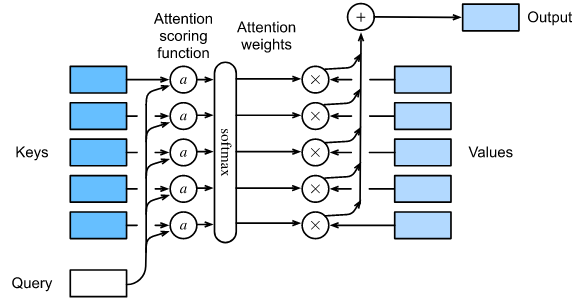
reference: https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html

# convenience functions
+ ### masked softmax operation
+ ### batch matrix multiplication

### masked softmax operation  

針對文本不等長問題, 經常解決的的方法是補零對齊, 也因此產生許多不必要的值, 因此我們想讓模型專注在有意義的值上面, 常用的解決方法是遮掉無意義的值, 具體實現方法為, 在進入softmax前,給無意義的值一個很大得負數(sample中給定-1e6),使得softmax後的結果中無意義的值為0

In [4]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        '''
        return matrix(False are masked elements)
        
        [[ True,  True, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True, False] ]
        '''    
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]

        # '~': inverse binary 
        X[~mask] = value
        return X
    
    # if don't need to mask return softmax output on the last dim
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    
    # need to mask
    else:
        # shape <- input tensor shape
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
            '''
            torch.repeat_interleave()
            
            parameter:
            ----------
            input: input_tensor(type: torch.Tensor)
            
            repeates: every elements repleat times(type: torch.Tensor or int)
            
            dim: the dim which need to repeat
            '''
        else:
            # flatten
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# reference: https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html

masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

### batch matrix multiplication


$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b} \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c} 
$$

batch matrix multiplication (BMM) computes the element-wise product

$$\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$

In [16]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K).shape

torch.Size([2, 3, 6])

### additive attention
核心為對key, value做linear transformation後, 將結果相加  
使用dot-product作為attention socre function, 其中query, key 可為不同length(d)
***
  

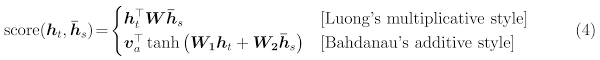




reference: https://www.kaggle.com/code/kmkarakaya/encoder-decoder-with-bahdanau-luong-attention

In [6]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        '''
        nn.LazyLinear()
        the weight and bias are of torch.nn.UninitializedParameter class. 
        They will be initialized after the first call to forward is done 
        and the module will become a regular torch.nn.Linear module.
        -------------------
        parameter:
        
        out_feature
        bias
        
        '''
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        # unsqueeze -> add dim
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        # squeeze -> del dim
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)
    
# reference: https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html

In [31]:
queries = torch.normal(0, 1, (2, 1, 20))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

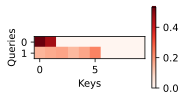

In [32]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### dot-product attention
利用inner-prodct計算query, key之間相似度  
使用dot-product作為attention socre function, 其中query, key 必須要有相同length(d)  
  
  
***

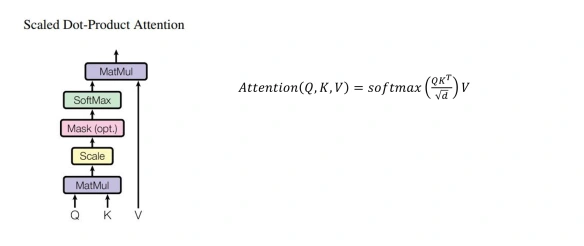

reference: https://jamesmccaffrey.wordpress.com/2020/09/10/trying-to-understand-scaled-dot-product-attention-for-transformer-architecture/

In [28]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads  # To be covered later

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None,
                window_mask=None):
        # get query vector length d
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        '''
        torch.bmm()
        Calculates the matrix multiplication of two tensors
        '''
        
        if window_mask is not None:  # To be covered later
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            # Shape of window_mask: (num_windows, no. of queries,
            # no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.
    num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        self.attention_weights = masked_softmax(scores, valid_lens)
        #print('attention_weights:',self.attention_weights)
        #print('afterDropout:',self.dropout(self.attention_weights))
        return torch.bmm(self.dropout(self.attention_weights), values)
# reference: https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html

In [29]:
queries = torch.normal(0, 1, (2, 1, 2))

'''
torch.normal()
Draws random numbers from a discrete normal distribution given parameters means,std

parameter:
---------------
means 
std
out 
''' 

keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))


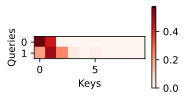

In [30]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')